In [2]:
#!/usr/bin/env python3
"""
Laminar flame‐speed calculation for a H2/NH3 premixed flame
using the Sandiego_19s40r mechanism.

Author : <your name>
Date   : 2025-07-08
"""

from pathlib import Path
import numpy as np
import cantera as ct

# ------------------------- 用户可调参数 --------------------------
MECH_FILE = "Otomo_32s213r.yaml"       # 机理文件
PHI       = 1.0                          # 当量比
T_IN      = 298.0                        # 入口温度 [K]
P_IN      = ct.one_atm                   # 入口压力 [Pa]
FUEL      = {"H2": 0.5, "NH3": 0.5}      # 燃料摩尔分率
OXIDIZER  = {"O2": 1.0, "N2": 3.76}      # 氧化剂摩尔分率（空气）
WIDTH     = 0.04                         # 计算域宽度 [m]
N_POINTS  = 12                           # 均匀初始网格节点数
LOGLEVEL  = 1                            # 求解日志级别 (0–8)
# -----------------------------------------------------------------

# 1. 构建气体对象并设定预混物状态 -----------------------------------
gas = ct.Solution(MECH_FILE, transport_model="mixture-averaged")
gas.set_equivalence_ratio(PHI, fuel=FUEL, oxidizer=OXIDIZER)
gas.TP = T_IN, P_IN

# 2. 创建均匀初始网格 -------------------------------------------------
initial_grid = np.linspace(0.0, WIDTH, N_POINTS)

# 3. 设置自由火焰对象 -------------------------------------------------
flame = ct.FreeFlame(gas, grid=initial_grid)
flame.inlet.T = gas.T
flame.inlet.Y = gas.Y
flame.set_refine_criteria(ratio=3.0, slope=0.06, curve=0.12)

# 4. Mixture-averaged 传输模型求解 -----------------------------------
flame.transport_model = "mixture-averaged"
flame.solve(loglevel=LOGLEVEL, auto=True)
u_mix = flame.velocity[0]
print(f"Laminar flame speed (mixture-averaged) : {u_mix:.3f} m/s")

# 5. Multicomponent 传输模型求解 -------------------------------------
flame.transport_model = "multicomponent"
flame.solve(loglevel=LOGLEVEL)   # 二次求解无需 auto
u_multi = flame.velocity[0]
print(f"Laminar flame speed (multicomponent)   : {u_multi:.3f} m/s")

# 6. 保存结果 ---------------------------------------------------------
output = Path("laminar_flame.h5") if "native" in ct.hdf_support() else Path("laminar_flame.yaml")
output.unlink(missing_ok=True)           # 如已存在则先删除
flame.save(output, name="final",
           description=f"φ={PHI} H2/NH3 premixed flame")
flame.save("laminar_flame.csv", basis="mole", overwrite=True)
print(f"\nDetailed solution written to '{output}' and 'laminar_flame.csv'.")



*********** Solving on 12 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 1.068e-05  log(ss)= 6.31      

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 2.027e-05  log(ss)= 5.49      

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0001732  log(ss)= 4.243     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.00148    log(ss)= 3.587     

Attempt Newton solution of steady-state problem.
Newton steady-state solve succeeded.

Problem solved on [12] point grid(s).

.............................................................

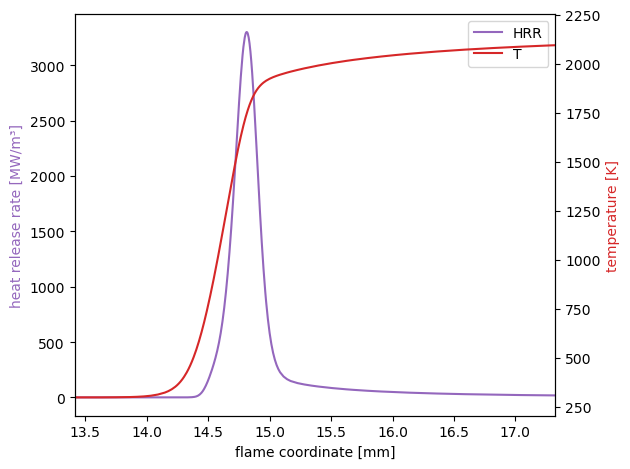

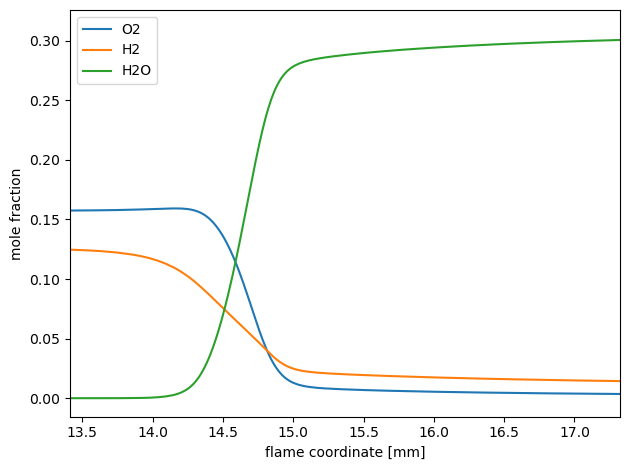

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 选定要可视化的火焰对象 ------------------------------------
f = flame                # 若你的对象名不是 flame，请改成实际变量名

# --- 2. 计算 z 坐标（mm）并确定可视范围 ----------------------------
z = 1000.0 * f.grid       # m → mm
# 找到温度上升区间的两端 (这里用 1% 和 95% 的温升阈值)
i_left  = np.where(f.T > f.T[0] + 0.01 * (f.T[-1] - f.T[0]))[0][0]
i_right = np.where(f.T > f.T[0] + 0.95 * (f.T[-1] - f.T[0]))[0][0]
z_left, z_right = z[i_left], z[i_right]
dz = z_right - z_left
z_left  -= 0.30 * dz      # 在两端各留 30% 余量，方便观察
z_right += 0.30 * dz

# --- 3. 温度 & 热释放率（HRR）双轴图 -------------------------------
fig, ax1 = plt.subplots()
ax1.plot(z, f.heat_release_rate / 1e6, color='C4', label='HRR')
ax1.set_ylabel('heat release rate [MW/m³]', color='C4')
ax1.set_xlabel('flame coordinate [mm]')
ax1.set_xlim(z_left, z_right)

ax2 = ax1.twinx()
ax2.plot(z, f.T, color='C3', label='T')
ax2.set_ylabel('temperature [K]', color='C3')

# 可选：组合图例
lines, labels = [], []
for ax in (ax1, ax2):
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
ax1.legend(lines, labels, loc='best')

plt.tight_layout()
plt.show()

# --- 4. 主要组分摩尔分率分布 --------------------------------------
major = ('O2', 'H2', 'H2O')
states = f.to_array()      # 返回 Cantera SolutionArray

fig, ax = plt.subplots()
ax.plot(z, states(*major).X, label=major)   # 同时画三条曲线
ax.set_xlabel('flame coordinate [mm]')
ax.set_ylabel('mole fraction')
ax.set_xlim(z_left, z_right)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

T = f.T            # 温度分布 [K]
x = f.grid         # 物理坐标 [m]
dTdx = np.gradient(T, x)
max_grad = np.max(np.abs(dTdx))            # 最大温度梯度 [K/m]

delta_L = (T.max() - T.min()) / max_grad   # 火焰热厚度 [m]
S_L      = f.velocity[0]                   # 层流火焰速度 [m/s]
tau_f    = delta_L / S_L                   # 火焰特征时间 [s]

print(f"Thermal thickness δ_L = {delta_L*1e3:.3f} mm")
print(f"Characteristic time τ_f = {tau_f*1e3:.3f} ms")
# ------------------------------------------------------------------


Thermal thickness δ_L = 0.536 mm
Characteristic time τ_f = 1.445 ms
